# Original Problem

For previous integrations, a reduced numerical precision approach appeared to work ok: https://arxiv.org/abs/2104.15076


However if we try the same with more 'realistic systems', low precision starts to fail, whereas the addition of stochastic rounding seems to fix this failure. This is illustrated in the plot below from A. Paxton:


![title](../../adam.png)


Note that 10RN is immediatley wrong from t=0 compared to 10SR. This means that we can integrate for shorter times when debugging this problem



# Hypothesised cause

After some digging, at least some of this difference can be traced back to a small/subtle bug in `dyn_geop.f90` which calcualates the spectral geopotential

![title](../../code_screenshot.png)

The conversions back and forth between Celsius and Kelvin on L26 and L45 introduces unwanted errors in the spectral temperature i.e. this subroutine is actually modifying the global variable `t(1,1,:,:)`.

We have made edits to correct for this on L23 and L48.

Now let us compare the 'old' method with the 'new' method.



# 1. Short timescales (10days) - high I/O resolutions

Rather than the long timescales in the original plot from Adam, lets just integrate for 10 days, with I/O every day:

In [13]:
#Import everything
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import pandas as pd
import seaborn as sns
import sys
from collections import defaultdict
from tqdm.notebook import tqdm


def surface_slice(y,i,j,already_surface, average, weights):
    
    
    #Get values at surface
    if already_surface is False:
        y_surface =  y[:,0]
    else:
        y_surface = y
    
    
    
    if average is True:
        ygrid = y_surface.weighted(weights).mean(("longitude", "latitude")).data #average across every surface grid point
        
    else:
        #Select values at only a particular gridpoint
        ygrid = y_surface[:,i,j].data 
    
  
    return ygrid


def get_weights(df,weighting):
    
    
    temp_file = df.temperature
    weights = np.cos(np.deg2rad(temp_file.latitude))
    
    if weighting is False:
        weights = weights/weights #=1
        
    weights.name = "weights"
    
    return weights


def extract_file_data(df,i,j,columns,weights,average,surface):
    
    
    data = [surface_slice(getattr(df,
                                  columns[k]),
                                   i,j,
                                   already_surface=surface, 
                                   average=average,
                                   weights = weights) for k in range(len(columns))]
    
    
    dictionary = {columns[i]: data[i] for i in range(len(columns))}
    df_out = pd.DataFrame(dictionary)
    
    
    return df_out



def extract_file_info(d):
    
    #Mapping between levels
    level_dict = {'L1': 'El Nino Static SST. ablco2=6',
                  'L2': 'EC Earth SST. ablco2=6',
                  'L3': 'El Nino Static SST. ablco2=21',
                  'L4': 'EC Earth SST. ablco2=21'
                  }

    #Create some useful labels
    label = d.split('/')[-1]
    level = label.split('_')[1]
    prec = label.split('_')[2]
    rounding = label.split('_')[3]
    title = level_dict[level]
    
    keys = ['label', 'level', 'precision','title']
    values = [label,level,prec+'_'+rounding,title]
    dictionary = {keys[i]: values[i] for i in range(len(keys))}
    
    return dictionary


    
    
def process_nc_file(fname,average,weighting,columns,directory):    
    
        #Get data 
        df = xr.open_dataset(fname)
        
        #Get weights for latitude
        weights = get_weights(df,weighting)
        
        
        columns_3d  = columns
        data3d = extract_file_data(df,i,j,columns_3d,weights,average=average,surface = False) #can change surface bool if we are dealing with sole surface quantities

                
        #Get meta information
        f_info = extract_file_info(directory)
        index = data3d.index
        df_info = pd.DataFrame(f_info,index=index)
      
        #Create pandas df and append
        df_meta = pd.concat([data3d,df_info,],axis=1) 
        

        return df_meta
        
    
        
def process_all_data(all_directories,i,j,average,weighting,columns):

    #Empty arrays to hold data
    dfs = []
    

    for d in tqdm(all_directories): #for every directory
        df_LI = [] # df of solution level i
        
        nc_files = sorted(glob.glob(d+'/model_output*.nc'))
        for n in nc_files: #for every model.nc file

        
            df_meta = process_nc_file(n,average,weighting,columns,d)
            df_LI.append(df_meta)
        
        df_LI = pd.concat(df_LI,ignore_index=True)
        df_LI['X'] = np.arange(len(df_LI))
        
        #Add append to bigger array
        
        dfs.append(df_LI)
            
    #Bring all together
    df = pd.concat(dfs)

    return df


def plot_temperature_levels(df,show_markers,fig_title,xlimits,ylimits,y):


    
    h,w = 20,10

    sns.set_theme(context='notebook', 
                  style='whitegrid', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    nlevels = df['level'].nunique()
    levels = df['level'].unique()

    
    fig, axN = plt.subplots(nrows=1, ncols=nlevels, sharey=True, figsize=(h,w))
    axes= fig.axes
    


    for i in range(len(levels)):
        
        l = levels[i]
        ax = axes[i]
    
    
        df_level = df[df['level']==l]
        level_title = df_level['title'].unique()[0]
  
        if y == 'temperature':
            ax.set_ylabel("Gloabl Mean Surface Temperature (K)", fontsize = 20)
            ax.set_title(level_title, fontsize = 10)
            ax.set_ylim(ylimits)
        else:
            ax.set_ylabel(y, fontsize = 20)

        p = sns.lineplot(data=df[df['level']==l], x="X", y=y, hue="precision",ax=ax,style='precision',markers=show_markers)

        p.set_xlabel("Time (days)", fontsize = 20)
        


            
            
        p.set_xlim(xlimits)


        p.legend().set_title(None)

    fig.suptitle(fig_title, fontsize = 20)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    







In [9]:
%load_ext autoreload
%autoreload 2


#Define root directory where data is stored
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/10day/'


old_dirs = glob.glob(root+'old/*') #using old/classic method
new_dirs = glob.glob(root+'new/*') #with bug fix

    
i,j = None,None #Not needed here. Used elsewhere for selecting gridpoint
selected_columns = ['temperature']



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Extract all data

kwargs = {'i':i,
         'j':j,
         'average': True,
         'weighting':True,
         'columns': selected_columns}


df_old_10day = process_all_data(old_dirs,**kwargs)
df_new_10day = process_all_data(new_dirs,**kwargs)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

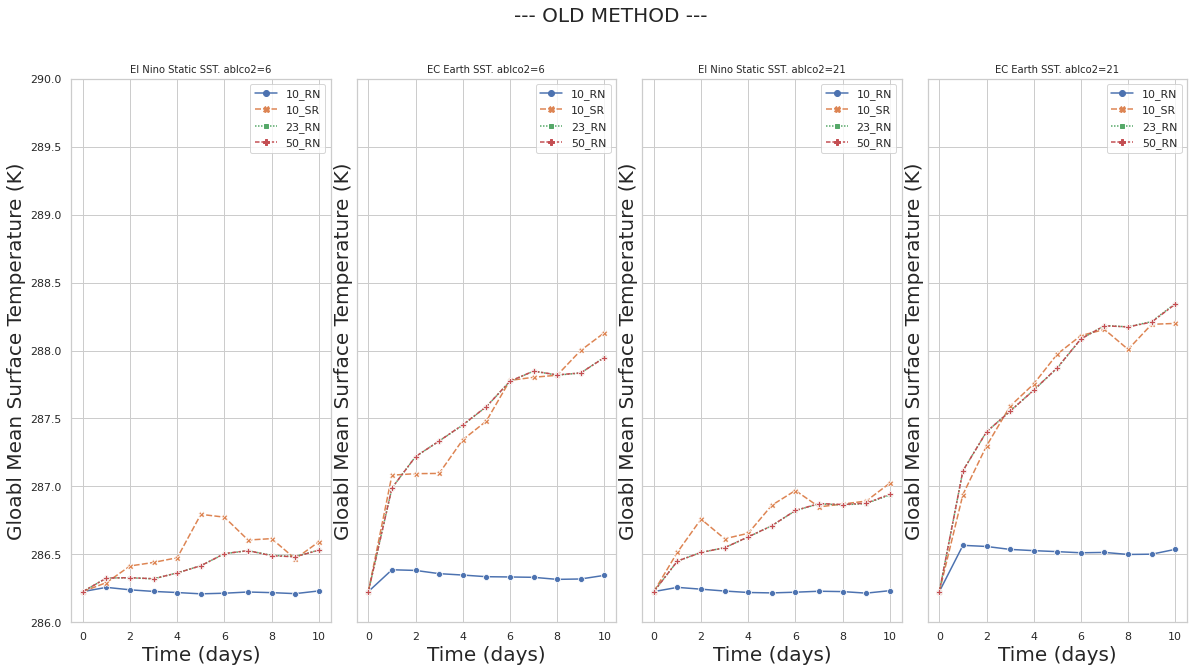

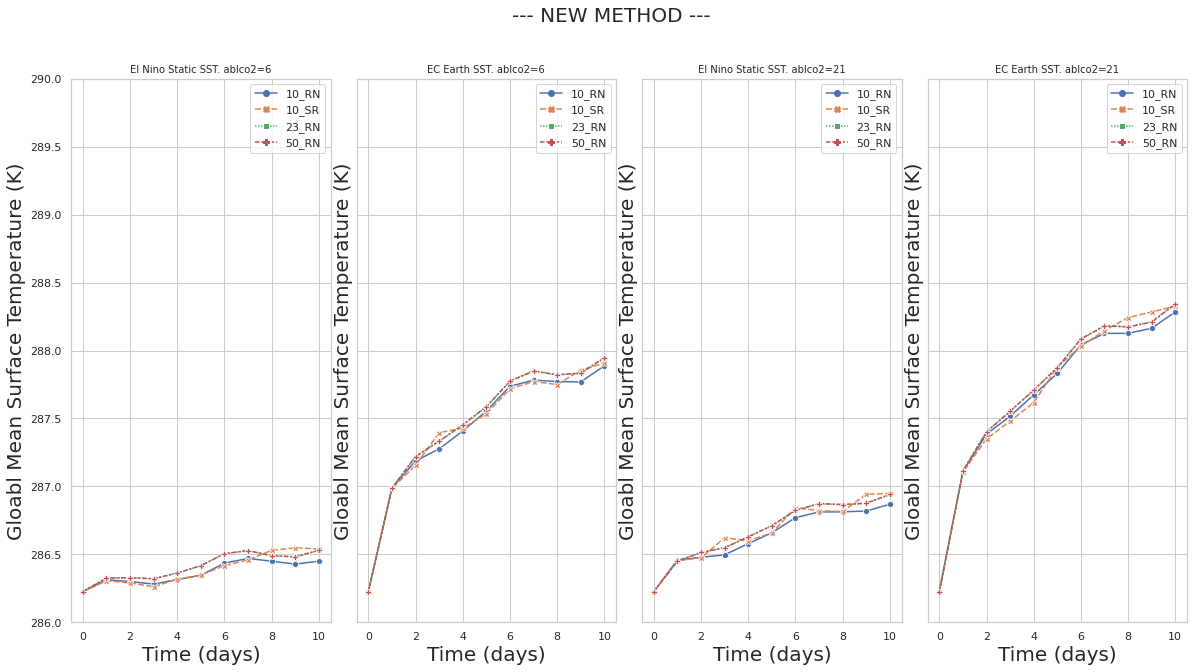

In [14]:


plot_kwargs = {'show_markers': True,
               'xlimits': None,
               'ylimits': (286,290),
               'y': 'temperature'}




plot_temperature_levels(df_old_10day.reset_index(),fig_title='--- OLD METHOD ---',**plot_kwargs)
plot_temperature_levels(df_new_10day.reset_index(),fig_title='--- NEW METHOD ---',**plot_kwargs)

* In the old case, before the fix, we can see extreme stagnation in the 10bit RN solution

* Note that we also observe stagnation even in the static El Nino case. This was likely not noted before since the temperature is effectively static which masks the effects of stagnation

* Once the bug fix has been implemented (`df_new`) we can see that the solutions agree.

Ok but that is just for 10 days. Lets now do some longer timescales

# 2. Medium timescales (1 year) - I/O still at 1 day

To save time we now drop the L3 and L4 runs and just focus on comparing El Nino SST with EC Earth SST.





  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

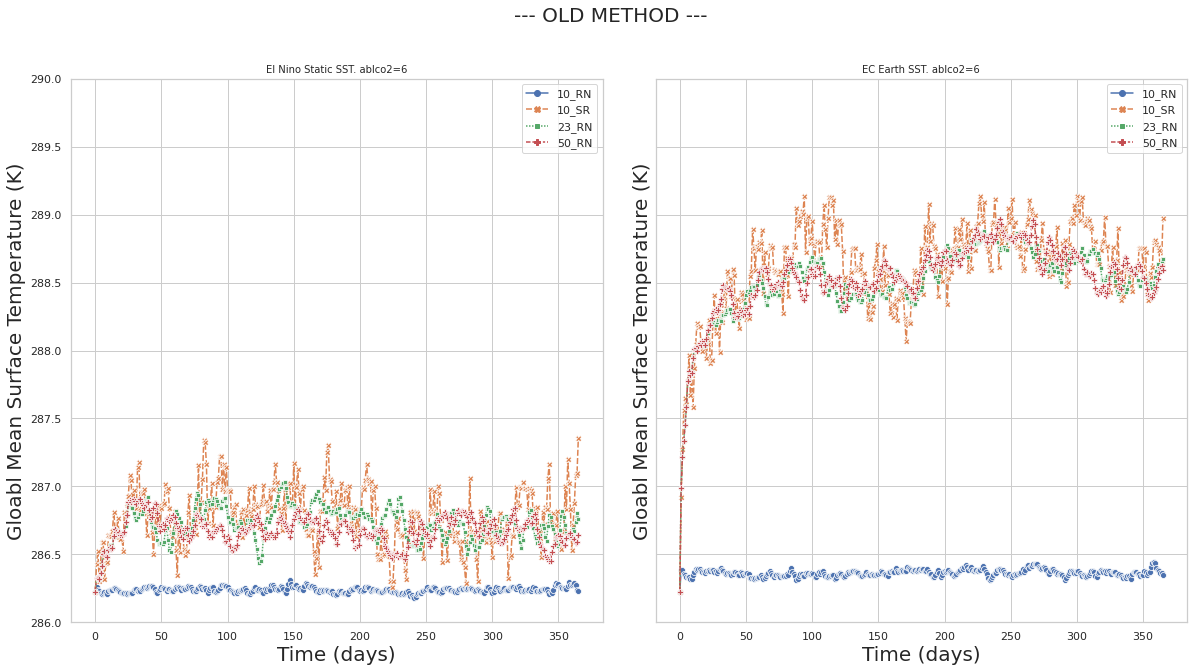

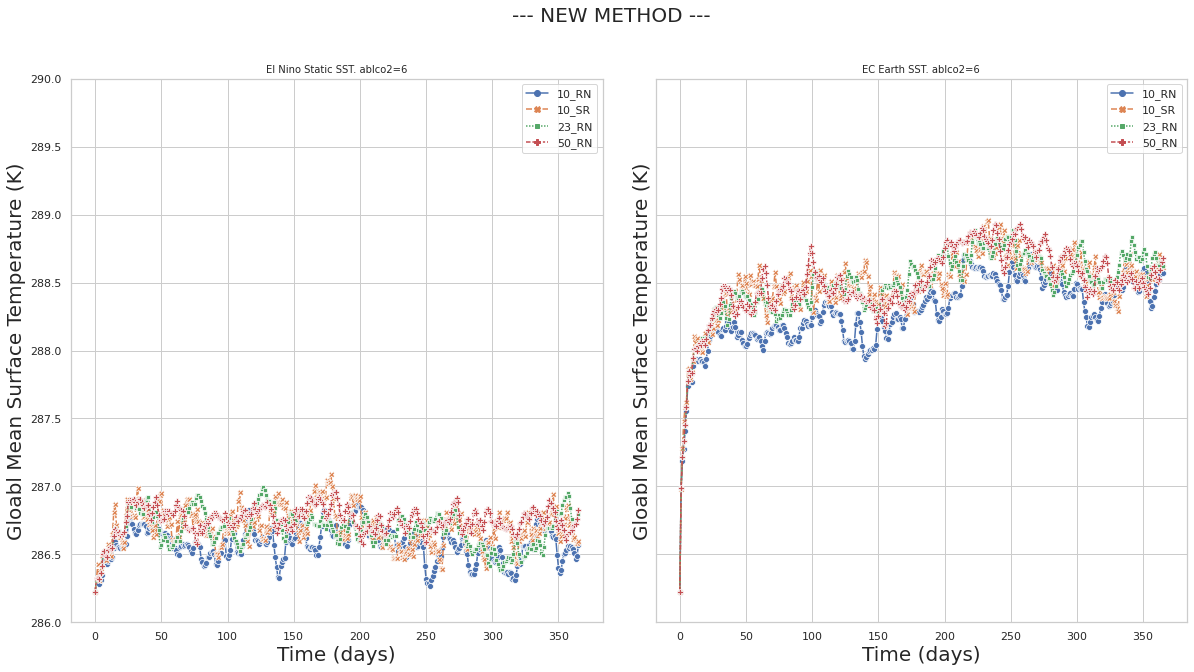

In [15]:

#Define root directory where data is stored
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/1year/'
old_dirs_1year = glob.glob(root+'old/*') #using old/classic method
new_dirs_1year = glob.glob(root+'new/*') #with bug fix

    
#Extract all data
df_old_1year = process_all_data(old_dirs_1year,**kwargs)
df_new_1year = process_all_data(new_dirs_1year,**kwargs)


#and plot it 
plot_temperature_levels(df_old_1year.reset_index(),fig_title='--- OLD METHOD ---',**plot_kwargs)
plot_temperature_levels(df_new_1year.reset_index(),fig_title='--- NEW METHOD ---',**plot_kwargs)




* As in the 10 day case, the new method > old method, fixing the severe stagnation observed previously

* However it does appear that there is still an error in the 10 bit solution that is fixed by 10bit + SR.


This is a bit noisy to follow plotting every point. Lets smooth it out by taking an average every 100 days:

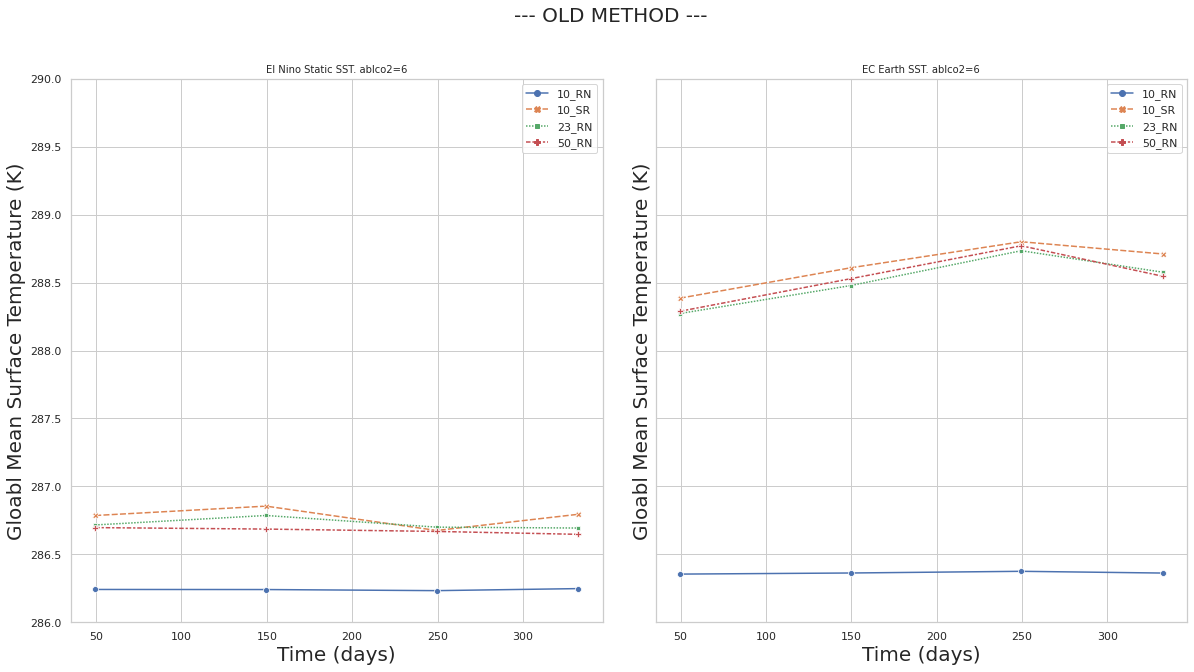

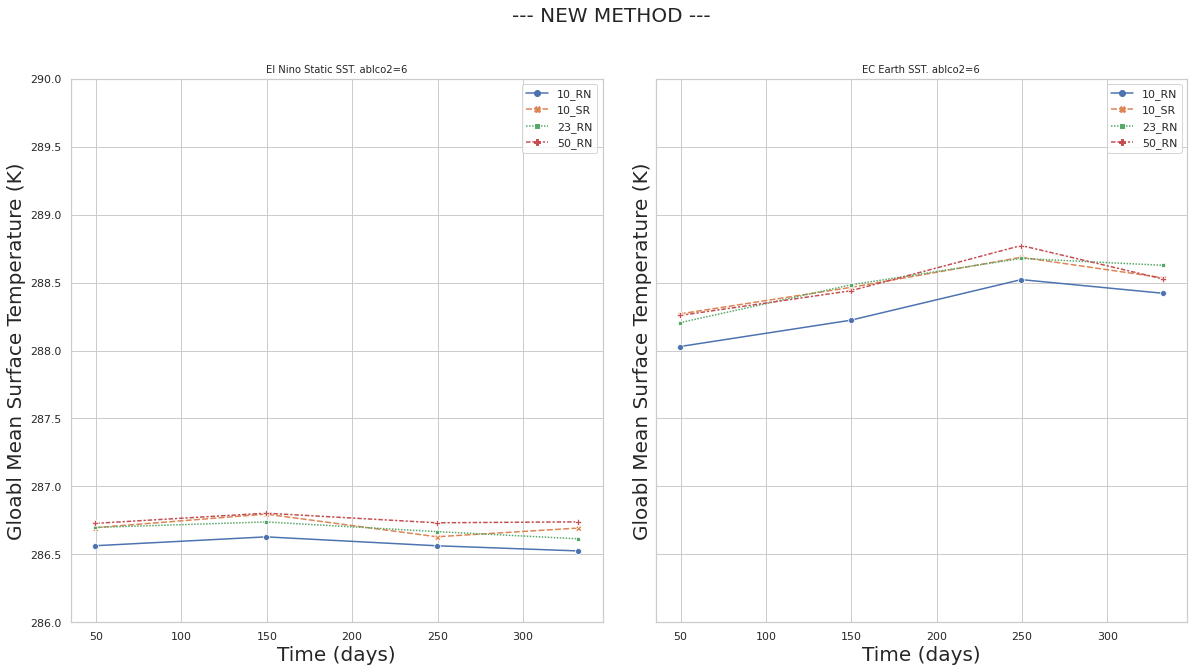

In [22]:
plot_kwargs = {'show_markers': True,
               'xlimits': None,
               'ylimits': (286,290),
               'y': 'temperature'}



window = 100 #window length to average over in days


df_old_1year_mean = df_old_1year.groupby([df_old_1year.index//window, 'label','level','precision', 'title'],as_index=False).mean()
df_new_1year_mean = df_new_1year.groupby([df_new_1year.index//window, 'label','level','precision', 'title'],as_index=False).mean()



plot_temperature_levels(df_old_1year_mean,fig_title='--- OLD METHOD ---',**plot_kwargs)
plot_temperature_levels(df_new_1year_mean,fig_title='--- NEW METHOD ---',**plot_kwargs)


* Conclusions as previous: bug fix massively improves the solution, however even with the fix the addition of SR appears to improve the solution.



So that is 10 days and 1 year. Lets try on more 'climate-y' timescales and integrate for 10 years:



# 3. Long timescales - 10 years

This time we didnt bother with the old method, and just do a run using the bug fix



  0%|          | 0/8 [00:00<?, ?it/s]

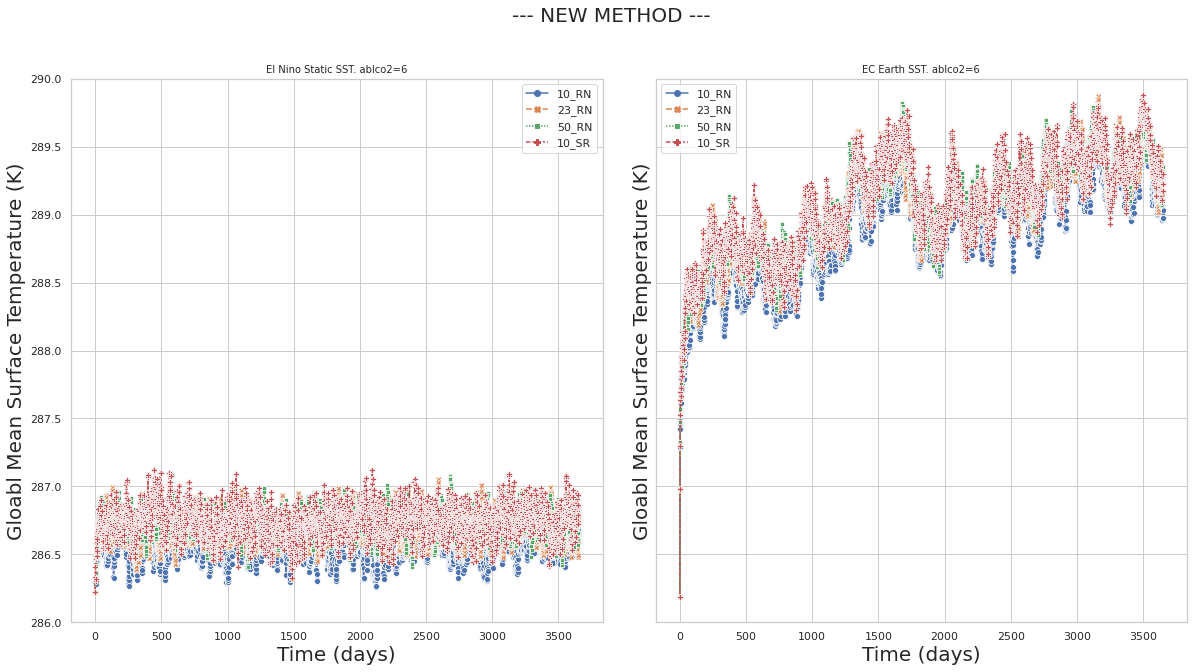

In [18]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/10year/'
dirs_10year = glob.glob(root+'*') 


#Extract all data
df_new_10year = process_all_data(dirs_10year,**kwargs)



plot_kwargs = {'show_markers': True,
               'xlimits': None,
               'ylimits': (286,290),
               'y': 'temperature'}



#and plot it 
plot_temperature_levels(df_new_10year.reset_index(),fig_title='--- NEW METHOD ---',**plot_kwargs)





Again this is quite hard to follow with all the points. Lets smooth it out a bit:

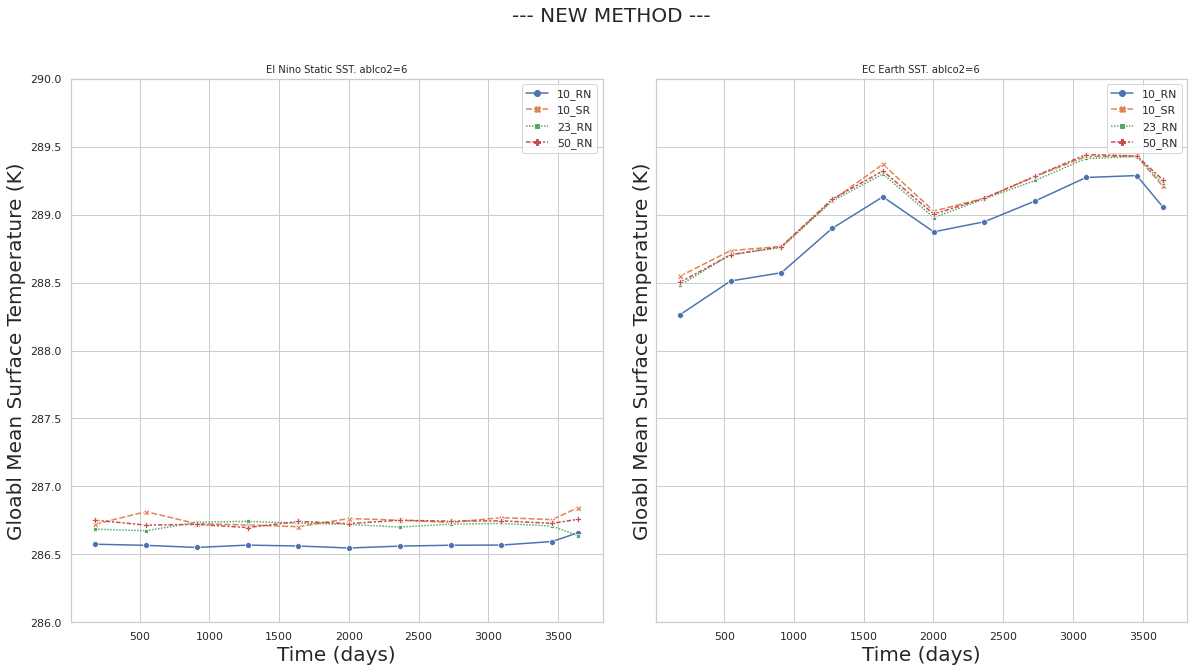

In [19]:
window = 364 #window length to average over in days
df_new_10year_mean = df_new_10year.groupby([df_new_10year.index//window, 'label','level','precision', 'title'],as_index=False).mean()
plot_temperature_levels(df_new_10year_mean,fig_title='--- NEW METHOD ---',**plot_kwargs)

# Summary

Severe stagnation at reduced precision at both L1 and L2 is caused by a bug in the spectral geopotential calculations. If we fix this bug the stagnation is fixed, but a small linear shift is observed on long timescales

---